# Lesson 22 activity: unsupervised learning

## Learning objectives

## Notebook setup

### Imports

In [1]:
#%pip install plotly
#%pip install nbformat


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Dataset

In [3]:
df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit3/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20396 non-null  float64
 1   latitude            20431 non-null  float64
 2   housing_median_age  20401 non-null  float64
 3   total_rooms         20432 non-null  float64
 4   total_bedrooms      20228 non-null  float64
 5   population          20421 non-null  float64
 6   households          20425 non-null  float64
 7   median_income       20408 non-null  float64
 8   median_house_value  20411 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Task 1: prepare data for clustering

Prepare the housing dataset for k-means clustering by completing the following steps:

- Check for and handle any missing values in the dataset
- Standardize the features using `StandardScaler` to ensure all variables are on the same scale

In [5]:
# Check for missing values
print('Missing values per column:')
print(df.isna().sum())

Missing values per column:
longitude             244
latitude              209
housing_median_age    239
total_rooms           208
total_bedrooms        412
population            219
households            215
median_income         232
median_house_value    229
dtype: int64


In [6]:
# Handle missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print(f'Dataset shape: {df.shape}')
print(f'Missing values after imputation: {df.isna().sum().sum()}')

Dataset shape: (20640, 9)
Missing values after imputation: 0


In [7]:
# Standardize the features
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(f'Scaled data shape: {df.shape}\n')
df.describe()

Scaled data shape: (20640, 9)



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04
mean,-3.932771e-15,1.035520e-15,-2.423557e-16,-3.855658e-17,1.101617e-16,-5.508083e-17,4.131062e-17,-9.363741e-17,2.423557e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-2.394486e+00,-1.454490e+00,-2.207552e+00,-1.209921e+00,-1.277612e+00,-1.259369e+00,-1.304421e+00,-1.780626e+00,-1.668252e+00
25%,-1.106024e+00,-7.965470e-01,-8.506844e-01,-5.453743e-01,-5.750127e-01,-5.639226e-01,-5.742684e-01,-6.872440e-01,-7.543808e-01
50%,5.283658e-01,-6.414605e-01,2.728894e-02,-2.333222e-01,-2.439574e-01,-2.299314e-01,-2.366710e-01,-1.771151e-01,-2.335399e-01
75%,7.790392e-01,9.751993e-01,6.658150e-01,2.351007e-01,2.609615e-01,2.661830e-01,2.762678e-01,4.576797e-01,5.020717e-01
max,2.639035e+00,2.967826e+00,1.863051e+00,1.685969e+01,1.407002e+01,3.034932e+01,1.460977e+01,5.880659e+00,2.548924e+00


## Task 2: cluster data with k-means

Apply k-means clustering to the prepared data:

- Use the elbow method to determine the optimal number of clusters (k)
  - Test k values from 2 to 10
  - Plot the within-cluster sum of squares (inertia) for each k value
  - Choose an appropriate k value based on the elbow in the plot
- Fit a `KMeans` model with the chosen k value using `random_state=315`
- Add the cluster labels as a new column to the original dataframe
- Create a visualization to show the distribution of data points across clusters

**Hints:**
- The `inertia_` attribute of a fitted KMeans model gives you the within-cluster sum of squares
- A simple loop can help you test multiple k values and store their inertia values
- Use `sklearn.manifold.TSNE` to collapse the features into two dimensions for plotting

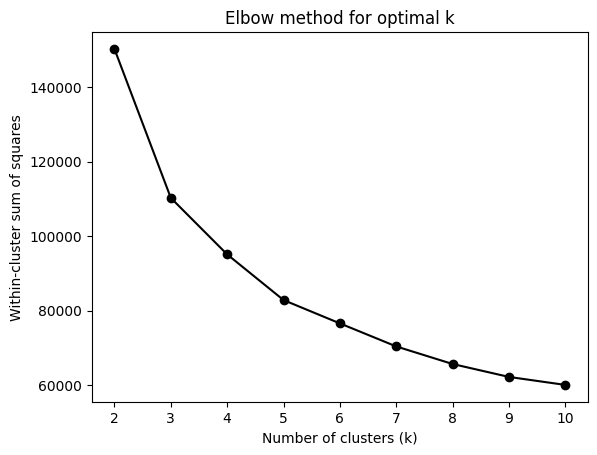

In [8]:
# Use elbow method to find optimal k
inertias = []
k_values = range(2, 11)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=315)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.title('Elbow method for optimal k')
plt.plot(k_values, inertias, marker='o', color='black')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares')
plt.show()

In [9]:
# Based on the elbow plot, choose k (typically where the curve bends)
optimal_k = 3

In [10]:
# Fit KMeans with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=315)
cluster_labels = kmeans_final.fit_predict(df)

# Add cluster labels to the cleaned dataframe
df['cluster'] = cluster_labels

print(f'Cluster distribution:')
print(df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0     8231
1    10665
2     1744
Name: count, dtype: int64


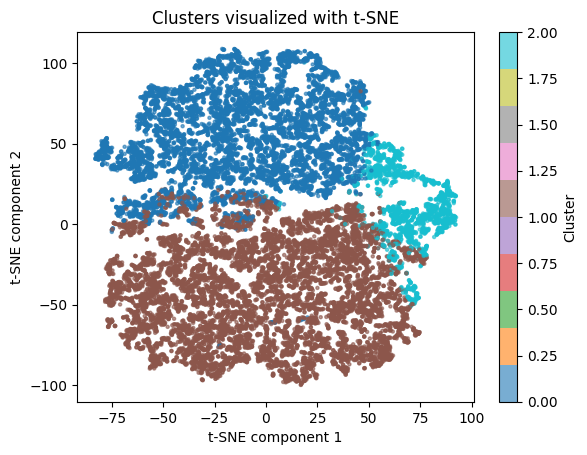

In [11]:
# Visualize clusters using t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=315)
X_tsne = tsne.fit_transform(df.drop('cluster', axis=1))

plt.title('Clusters visualized with t-SNE')
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', s=5, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

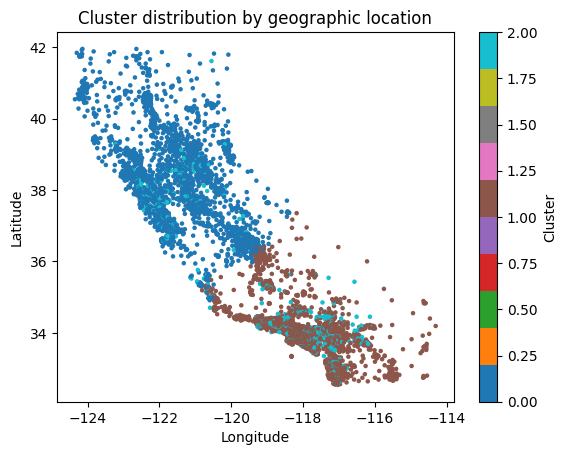

In [12]:
# Plot cluster distribution by geographic location
df_original = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit3/housing.csv')
df_original['cluster'] = cluster_labels

plt.title('Cluster distribution by geographic location')

scatter = plt.scatter(
    df_original['longitude'], 
    df_original['latitude'], 
    c=cluster_labels, 
    cmap='tab10', 
    s=5
)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
# Plot clusters in 3D using lat, lon and median house value
fig = px.scatter_3d(
    df_original,
    x='longitude',
    y='latitude',
    z='population',
    color=cluster_labels.astype(str),
    labels={
        'longitude': 'Longitude',
        'latitude': 'Latitude',
        'population': 'Population',
        'color': 'Cluster'
    },
    title='Cluster distribution in 3D',
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_traces(marker=dict(size=2))
fig.show()

## Task 3: train a supervised model to assign cluster membership

Build a supervised learning model that can predict cluster assignments for new data:

- Split the data into training and testing sets
- Use the scaled features from task 1 as the input and the cluster labels from task 2 as the label
- Train a classification model (such as `RandomForestClassifier` or `LogisticRegression`) to predict cluster membership
- Evaluate the model's performance on the test set using appropriate metrics (F1 score, precision, recall, confusion matrix)

In [14]:
# Split data into training and testing sets
train_df, test_df = train_test_split(df, random_state=315)

print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}\n')

Train df shape: (15480, 10)
Test df shape: (5160, 10)



In [15]:
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=315)
rf_classifier.fit(train_df.drop(columns='cluster'), train_df['cluster'])

# Make predictions on test set
y_pred = rf_classifier.predict(test_df.drop(columns='cluster'))

# Evaluate performance
print('Classification report:')
print(classification_report(test_df['cluster'], y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2117
           1       0.99      0.99      0.99      2624
           2       0.97      0.95      0.96       419

    accuracy                           0.99      5160
   macro avg       0.98      0.98      0.98      5160
weighted avg       0.99      0.99      0.99      5160



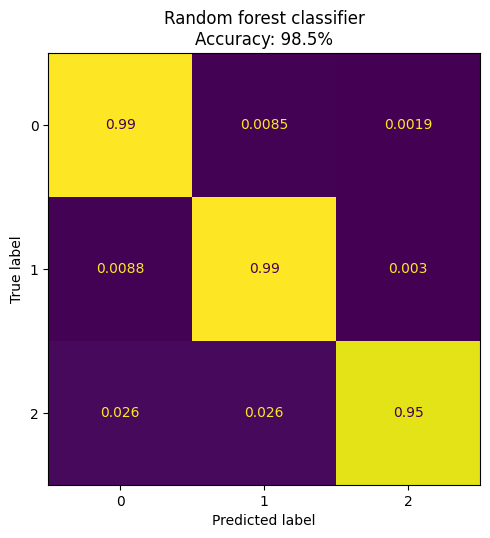

In [16]:
# Compare confusion matrices for baseline and trained model
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 6))

# Confusion matrix for constant 0 baseline
axs.set_title(f'Random forest classifier\nAccuracy: {accuracy_score(test_df["cluster"], y_pred)*100:.1f}%')

disp_constant = ConfusionMatrixDisplay.from_predictions(
    test_df['cluster'],
    y_pred ,
    normalize='true',
    ax=axs,
    colorbar=False
)

plt.tight_layout()
plt.show()